In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Разведывательный анализ данных

### Датасет для задачи на целевую переменную 'Соотношение матрица-наполнитель' (matrix-filler ratio)

In [3]:
matrix_filler_data = pd.read_csv('../data/data_processing/matrix_filler_ratio.csv', sep=';', index_col=0)
matrix_filler_data

matrix_filler_ratio      density  elasticity    hardener     epoxid  \
0                1.857143  2030.000000  738.736842   30.000000  22.267857   
1                1.857143  2030.000000  738.736842   50.000000  23.750000   
2                1.857143  2030.000000  738.736842   49.900000  33.000000   
3                1.857143  2030.000000  738.736842  129.000000  21.250000   
4                2.771331  2030.000000  753.000000  111.860000  22.267857   
...                   ...          ...         ...         ...        ...   
1018             2.271346  1952.087902  912.855545   86.992183  20.123249   
1019             3.444022  2050.089171  444.732634  145.981978  19.599769   
1020             3.280604  1972.372865  416.836524  110.533477  23.957502   
1021             3.705351  2066.799773  741.475517  141.397963  19.246945   
1022             3.808020  1890.413468  417.316232  129.183416  27.474763   

      temperature  surface_density  elasticity_on_stretching  \
0      100.000000       210.000000                 70.000000   
1      284.615385       210.000000                 70.000000   
2      284.615385       210.000000                 70.000000   
3      300.000000       210.000000                 70.000000   
4      284.615385       210.000000                 70.000000   
...           ...              ...                       ...   
1018   324.774576       209.198700                 73.090961   
1019   254.215401       350.660830                 72.920827   
1020   248.423047       740.142791                 74.734344   
1021   275.779840       641.468152                 74.042708   
1022   300.952708       758.747882                 74.309704   

      solidity_on_stretching       resin  cover_angle  cover_step  \
0                3000.000000  220.000000            0    4.000000   
1                3000.000000  220.000000            0    4.000000   
2                3000.000000  220.000000            0    4.000000   
3                3000.000000  220.000000            0    5.000000   
4                3000.000000  220.000000            0    5.000000   
...                      ...         ...          ...         ...   
1018             2387.292495  125.007669            1    9.076380   
1019             2360.392784  117.730099            1   10.565614   
1020             2662.906040  236.606764            1    4.161154   
1021             2071.715856  197.126067            1    6.313201   
1022             2856.328932  194.754342            1    6.078902   

      cover_strength  
0          57.000000  
1          60.000000  
2          70.000000  
3          47.000000  
4          57.000000  
...              ...  
1018       47.019770  
1019       53.750790  
1020       67.629684  
1021       58.261074  
1022       77.434468  

[1023 rows x 13 columns]

### Первые 22 записи вызывают сомения из-за  целых значений ряда показателей - density, surface_density, elasticity_on_stretching, resine.
### Такие целые значения по этим переменным сильно выделяются на фоне остальных наблюдений. 
### Есть предположение, что это 'грубый' ручной ввод данных, поэтому избавляемся от этих записей (наблюдений) без каких-либо значимых негативных последствий, т.к. всё ещё остаётся большое количество наблюдений.  

In [4]:
def highlighter_for_many(cell_value, values_to_highlight=[]):
    if cell_value in values_to_highlight:
        return 'background-color: red; color: white;'
    

def highlighter_for_cell(x, row_idx, col_idx):
    color = 'background-color: red; color: white;'
    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    df_styler.iloc[row_idx, col_idx] = color
    return df_styler

In [11]:
values_to_highlight_1 = [111.86, 21.25, 33, 100, 302, 313, 506, 540, 753, 748, 807, 535, 800, 889, 1421, 933, 1628, 827, 568, 3000, 1800, 2000, 2100, 1900, 1930, 2030, 1990, 1950, 1980, 1910, 2000, 2160, 1880, 1890, 1920, 30, 50, 129, 300, 210, 380, 1010, 220, 120, 470, 70, 75, 78]
matrix_filler_data.drop(columns=['cover_strength']).head(40).style.applymap(highlighter_for_many, values_to_highlight=values_to_highlight_1)

### И ещё вызывает подозрение единственное нулевое значение признака cover_strength ('Плотность нашивки') - лучше от него тоже избавиться.
### Но эта позиция и так попадат под удаление - находится среди Top22 строк на удаление.

In [12]:
matrix_filler_data.head(30).style.apply(highlighter_for_cell, row_idx=19, col_idx=11, axis = None)

In [13]:
matrix_filler_data = matrix_filler_data.loc[matrix_filler_data.index[23:], :].reset_index(drop=True)
matrix_filler_data

matrix_filler_ratio      density   elasticity    hardener     epoxid  \
0               2.587348  1953.274926  1136.596135  137.627420  22.344534   
1               2.499918  1942.595777   901.519947  146.252208  23.081757   
2               2.046471  2037.631811   707.570887  101.617251  23.146393   
3               1.856476  2018.220332   836.294382  135.401697  26.435515   
4               3.305535  1917.907506   478.286247  105.786930  17.874100   
..                   ...          ...          ...         ...        ...   
995             2.271346  1952.087902   912.855545   86.992183  20.123249   
996             3.444022  2050.089171   444.732634  145.981978  19.599769   
997             3.280604  1972.372865   416.836524  110.533477  23.957502   
998             3.705351  2066.799773   741.475517  141.397963  19.246945   
999             3.808020  1890.413468   417.316232  129.183416  27.474763   

     temperature  surface_density  elasticity_on_stretching  \
0     234.716883       555.893453                 80.803222   
1     351.231874       864.725484                 76.178075   
2     312.307205       547.601219                 73.817067   
3     327.510377       150.961449                 77.210762   
4     328.154579       526.692159                 72.345709   
..           ...              ...                       ...   
995   324.774576       209.198700                 73.090961   
996   254.215401       350.660830                 72.920827   
997   248.423047       740.142791                 74.734344   
998   275.779840       641.468152                 74.042708   
999   300.952708       758.747882                 74.309704   

     solidity_on_stretching       resin  cover_angle  cover_step  \
0               2587.342983  246.613117            1    4.000000   
1               3705.672523  226.222760            1    5.000000   
2               2624.026407  178.198556            1    5.000000   
3               2473.187195  123.344561            1    5.000000   
4               3059.032991  275.575880            1    5.000000   
..                      ...         ...          ...         ...   
995             2387.292495  125.007669            1    9.076380   
996             2360.392784  117.730099            1   10.565614   
997             2662.906040  236.606764            1    4.161154   
998             2071.715856  197.126067            1    6.313201   
999             2856.328932  194.754342            1    6.078902   

     cover_strength  
0         70.000000  
1         47.000000  
2         57.000000  
3         60.000000  
4         70.000000  
..              ...  
995       47.019770  
996       53.750790  
997       67.629684  
998       58.261074  
999       77.434468  

[1000 rows x 13 columns]

In [14]:
matrix_filler_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   matrix_filler_ratio       1000 non-null   float64
 1   density                   1000 non-null   float64
 2   elasticity                1000 non-null   float64
 3   hardener                  1000 non-null   float64
 4   epoxid                    1000 non-null   float64
 5   temperature               1000 non-null   float64
 6   surface_density           1000 non-null   float64
 7   elasticity_on_stretching  1000 non-null   float64
 8   solidity_on_stretching    1000 non-null   float64
 9   resin                     1000 non-null   float64
 10  cover_angle               1000 non-null   int64  
 11  cover_step                1000 non-null   float64
 12  cover_strength            1000 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 101.7 KB


In [15]:
matrix_filler_data.isna().sum()

matrix_filler_ratio         0
density                     0
elasticity                  0
hardener                    0
epoxid                      0
temperature                 0
surface_density             0
elasticity_on_stretching    0
solidity_on_stretching      0
resin                       0
cover_angle                 0
cover_step                  0
cover_strength              0
dtype: int64

In [16]:
matrix_filler_data.describe()

matrix_filler_ratio      density   elasticity     hardener  \
count          1000.000000  1000.000000  1000.000000  1000.000000   
mean              2.930612  1975.666791   739.950520   110.541116   
std               0.913939    73.796817   330.327013    28.304470   
min               0.389403  1731.764635     2.436909    17.740275   
25%               2.318526  1924.203433   498.438068    92.170589   
50%               2.907832  1977.574305   741.148111   110.162666   
75%               3.552539  2021.159498   962.851423   130.311975   
max               5.591742  2207.773481  1911.536477   198.953207   

            epoxid  temperature  surface_density  elasticity_on_stretching  \
count  1000.000000  1000.000000      1000.000000               1000.000000   
mean     22.243850   285.911287       483.024665                 73.328462   
std       2.406999    40.962756       280.811736                  3.119584   
min      14.254985   160.255843         0.603740                 64.054061   
25%      20.558296   258.539199       268.057473                 71.301753   
50%      22.230761   285.853960       452.972263                 73.247594   
75%      23.982115   313.581449       694.210382                 75.379739   
max      28.955094   413.273418      1399.542362                 82.682051   

       solidity_on_stretching        resin  cover_angle   cover_step  \
count             1000.000000  1000.000000   1000.00000  1000.000000   
mean              2467.184290   218.386876      0.50000     6.909904   
std                485.624616    59.819777      0.50025     2.560031   
min               1036.856605    33.803026      0.00000     0.037639   
25%               2143.834592   179.190489      0.00000     5.116518   
50%               2461.249253   217.277006      0.50000     6.913444   
75%               2760.163022   257.495647      1.00000     8.585130   
max               3848.436732   414.590628      1.00000    14.440522   

       cover_strength  
count     1000.000000  
mean        57.181470  
std         12.304355  
min         11.740126  
25%         49.821889  
50%         57.362576  
75%         64.986942  
max        103.988901

### Оценим парные диаграммы рассеяния данных.

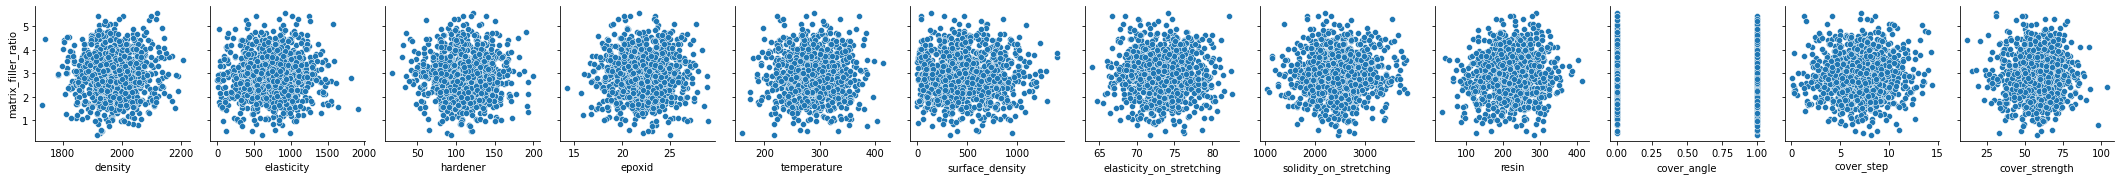

In [17]:
sns.pairplot(data=matrix_filler_data, x_vars=matrix_filler_data.columns[1:], y_vars=matrix_filler_data.columns[0]);

In [18]:
matrix_filler_data.corrwith(matrix_filler_data['solidity_on_stretching'])

matrix_filler_ratio         0.036288
density                    -0.074165
elasticity                  0.048217
hardener                   -0.066785
epoxid                     -0.031613
temperature                -0.026122
surface_density             0.013333
elasticity_on_stretching    0.011490
solidity_on_stretching      1.000000
resin                       0.026477
cover_angle                 0.025412
cover_step                 -0.056045
cover_strength              0.014987
dtype: float64

### Важно! 
### Полностью отсутствует линейная взаимосвязь признаков с целевой переменной (elastisity_onstretching = Модуль упругости при растяжении). Корреляция - околонулевая.
### Похоже, перспективы получить качественную модель регрессии крайне малы.

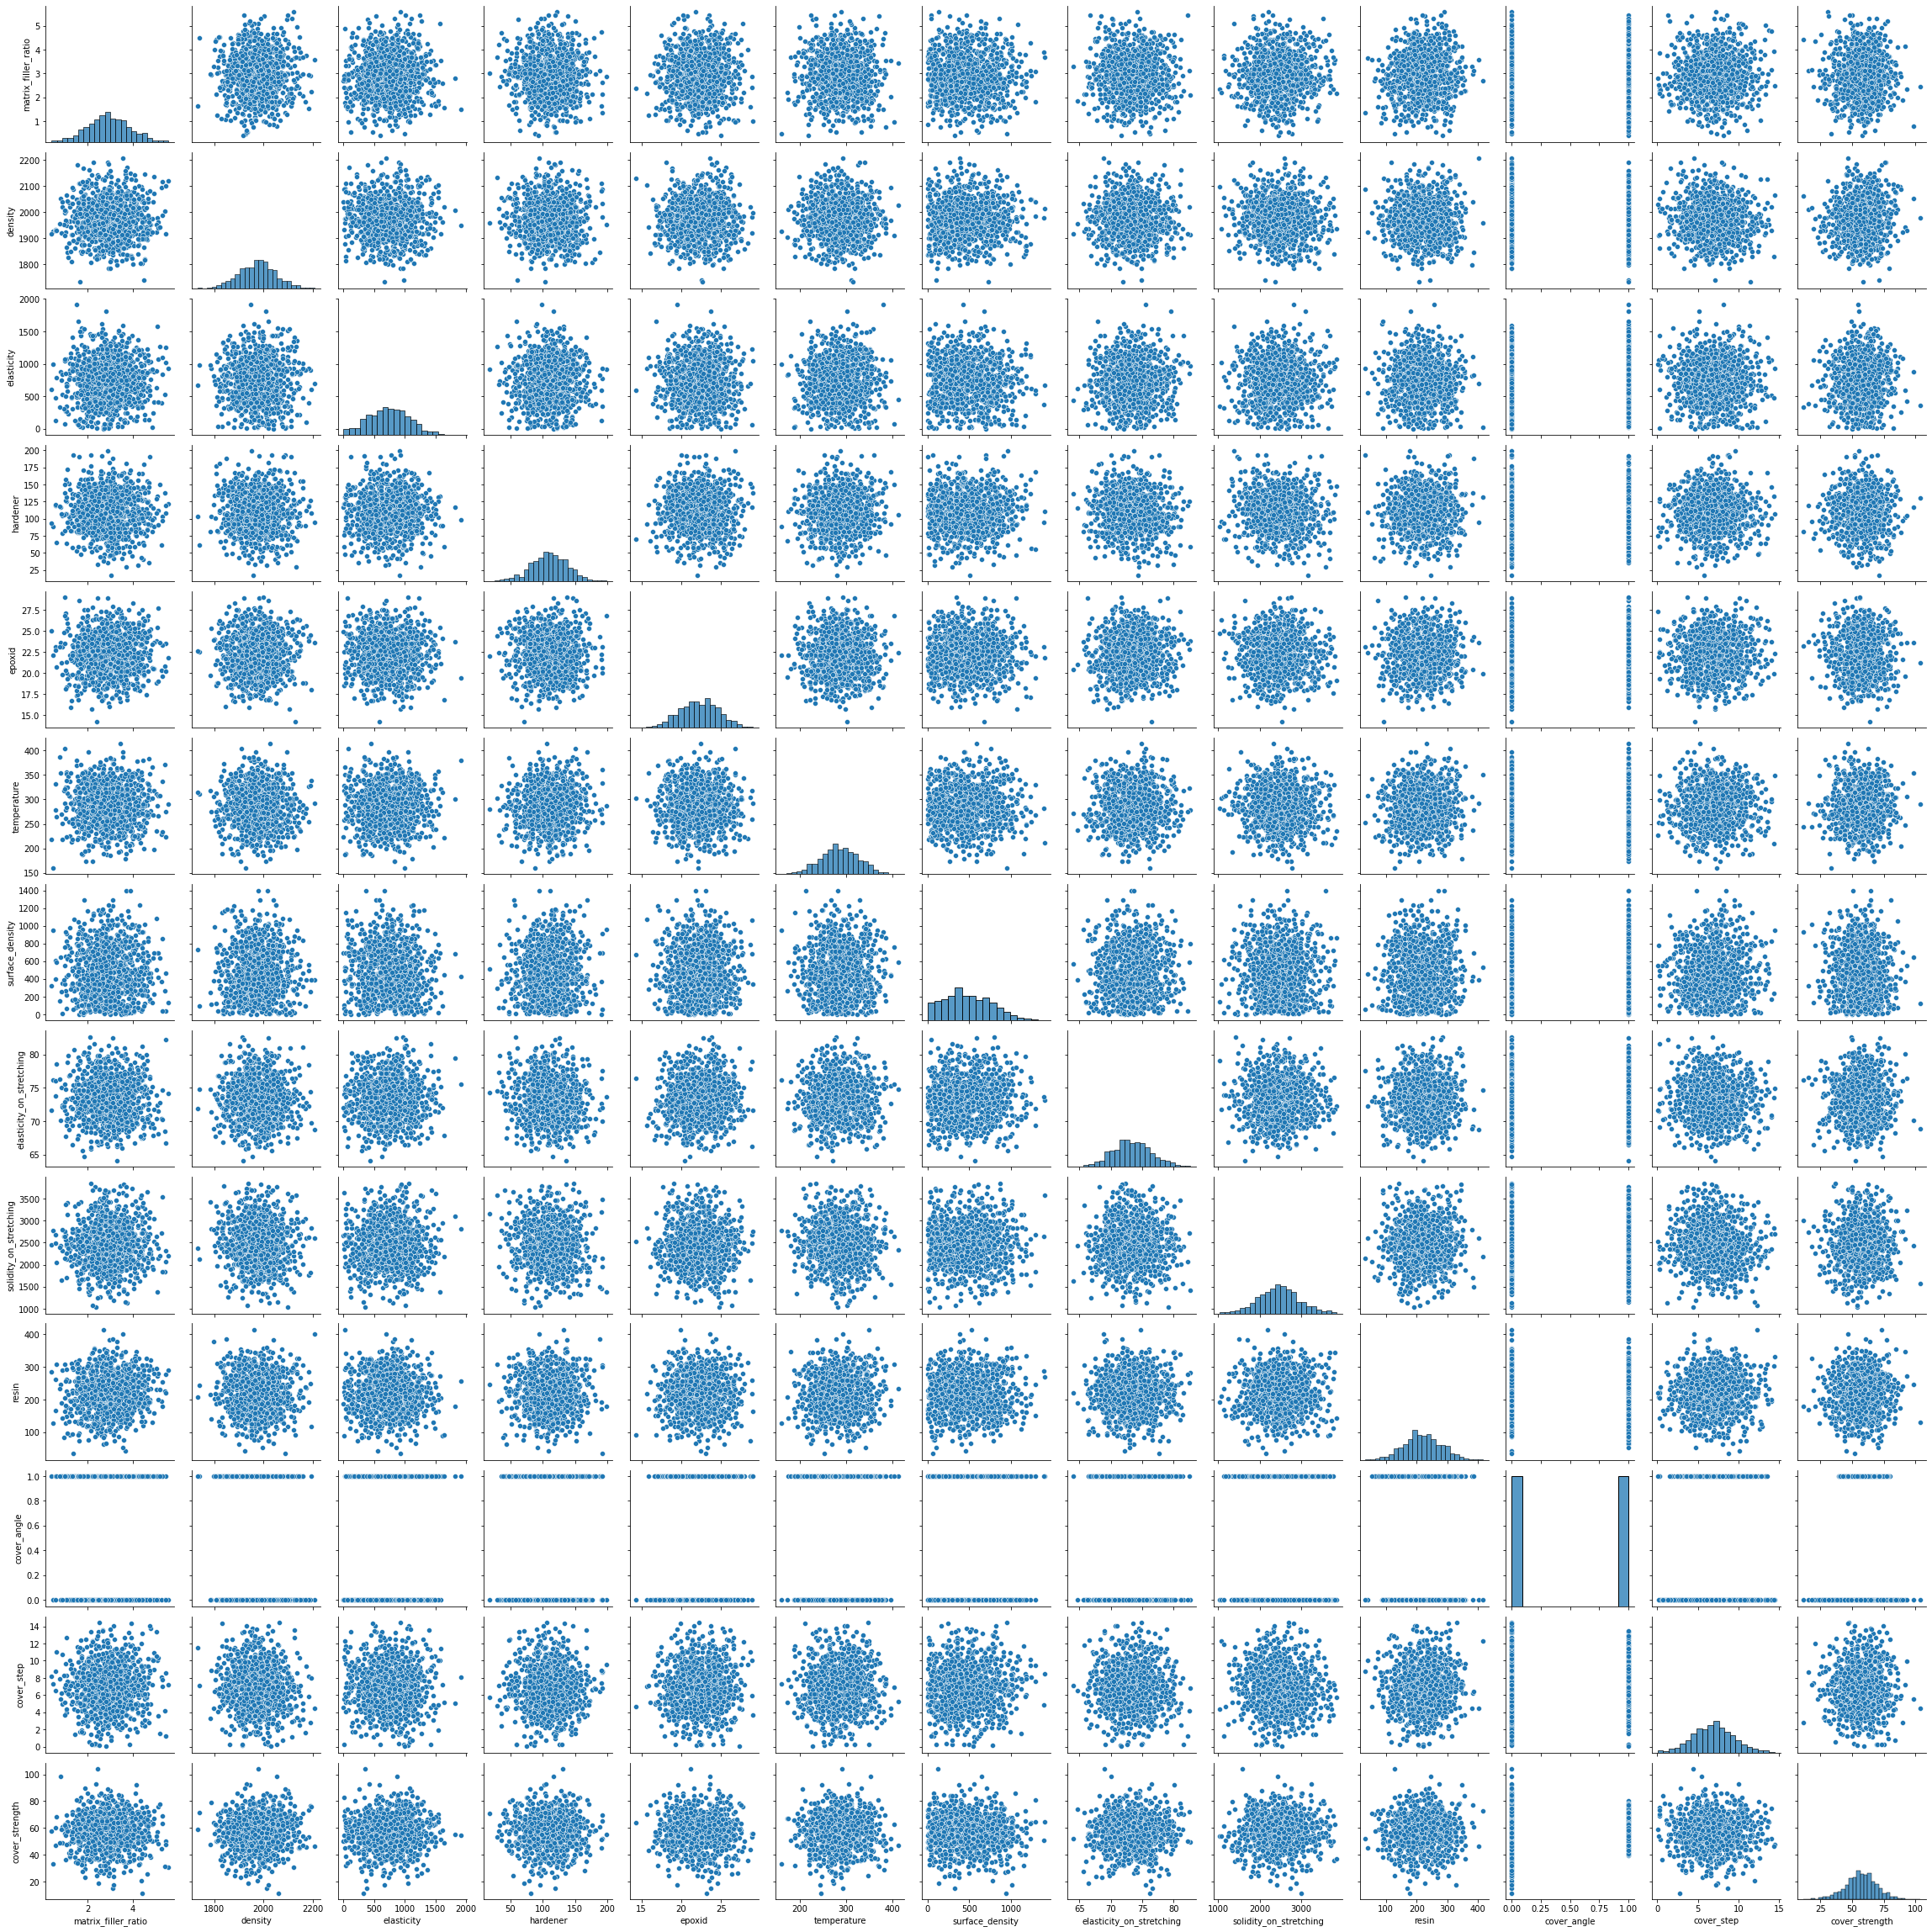

In [19]:
sns.pairplot(data=matrix_filler_data);

### Явные связи между признаками также отсутствуют.
### Перспективы получить какие-то новые признаки через feature engineering, видимо, тоже невелики. Но можно попробовать (а) парное перемножение признаков и (б) получить новые признаки через PCA (главне компоненты).   

### Далее про наблюдения и данные...
### Практически все признаки (то же касается и целевой переменной) имеют форму распределения очень близкую к нормальному, что хорошо.
### Но есть некоторые признаки, над которыми можно поработать для улучшения формы их распределения. 

For matrix_filler_ratio Shapiro-Wilk test says: normal
For density Shapiro-Wilk test says: normal
For elasticity Shapiro-Wilk test says: not normal
For hardener Shapiro-Wilk test says: normal
For epoxid Shapiro-Wilk test says: normal
For temperature Shapiro-Wilk test says: normal
For surface_density Shapiro-Wilk test says: not normal
For elasticity_on_stretching Shapiro-Wilk test says: normal
For solidity_on_stretching Shapiro-Wilk test says: normal
For resin Shapiro-Wilk test says: normal
For cover_step Shapiro-Wilk test says: normal
For cover_strength Shapiro-Wilk test says: not normal


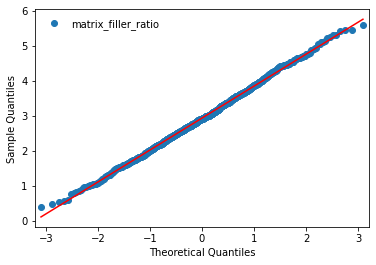

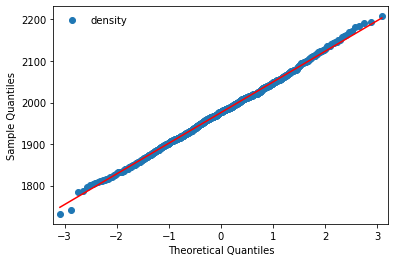

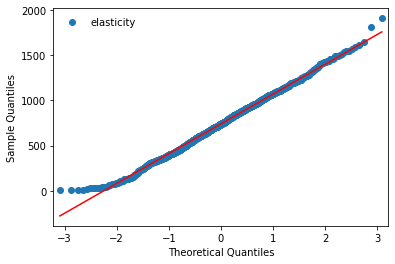

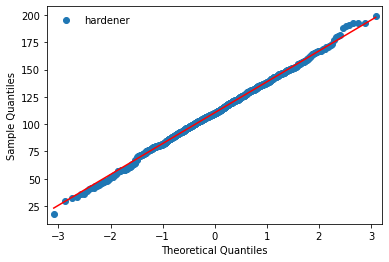

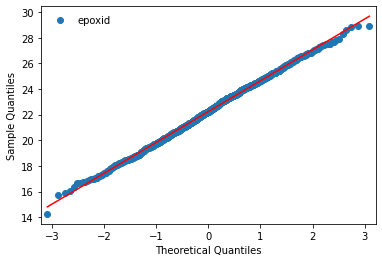

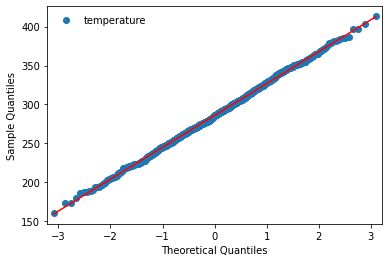

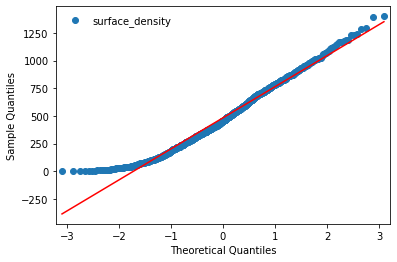

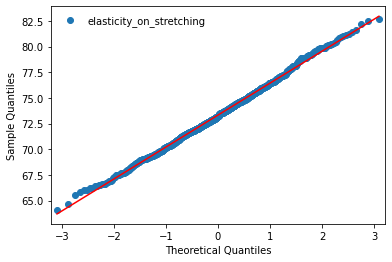

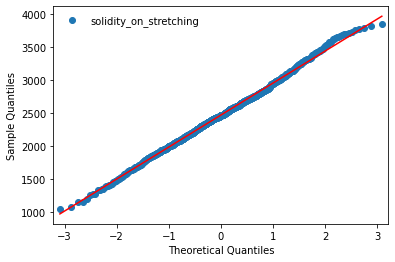

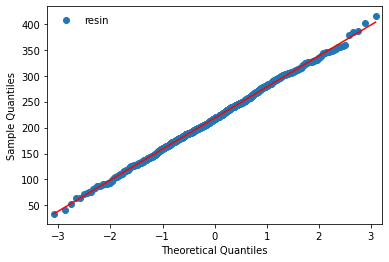

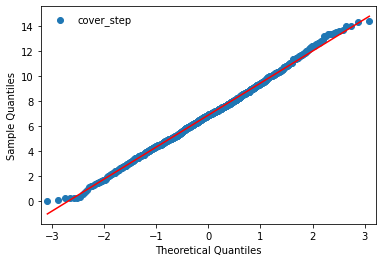

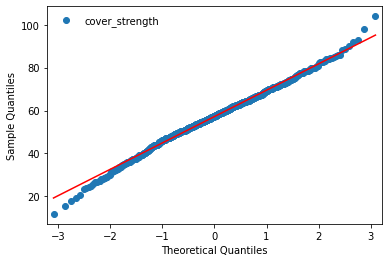

In [20]:
# Проверка на нормальность распределения
# Shapiro-Wilksays H0 hypothesis is that data is normally distributed

for variable_name in matrix_filler_data.columns.tolist():
    if variable_name != 'cover_angle':
        print(f'For {variable_name} Shapiro-Wilk test says: {"normal" if shapiro(matrix_filler_data[variable_name].values)[1] > 0.05 else "not normal"}')    
        sm.qqplot(matrix_filler_data[variable_name],  line='s', label=variable_name)
        plt.legend(frameon=False);

### Применяем boxcox трансформацию для признака 'elasticity' (модуль упругости)

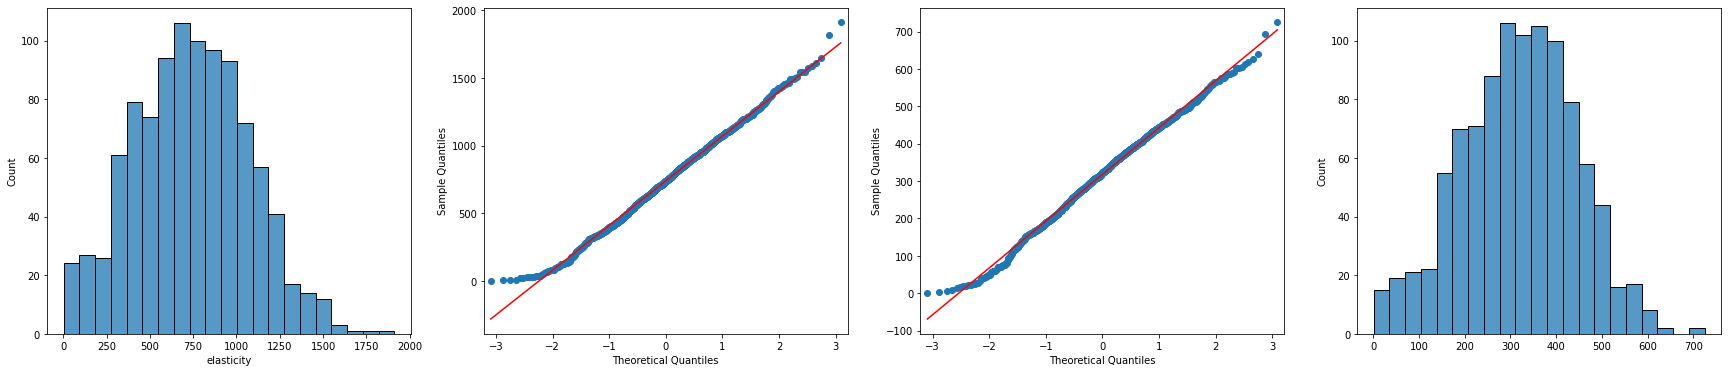

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
sns.histplot(matrix_filler_data['elasticity'], ax=ax[0])
sm.qqplot(matrix_filler_data['elasticity'], line='s', ax=ax[1])
sm.qqplot(boxcox(matrix_filler_data['elasticity'])[0], line='s', ax=ax[2])
sns.histplot(boxcox(matrix_filler_data['elasticity'])[0], ax=ax[3])
plt.show()

In [22]:
# Проверка на отсутствие негативных значений
matrix_filler_data['elasticity'].min() , boxcox(matrix_filler_data['elasticity'].values + 1)[0].min()

(2.4369087535075, 2.1857594002244976)

In [23]:
matrix_filler_data['elasticity_boxcox'], elasticity_boxcox_lambda = boxcox(matrix_filler_data['elasticity'].values + 1)

### Применяем boxcox трансформацию для признака 'surface density' (поверхностная плотность)

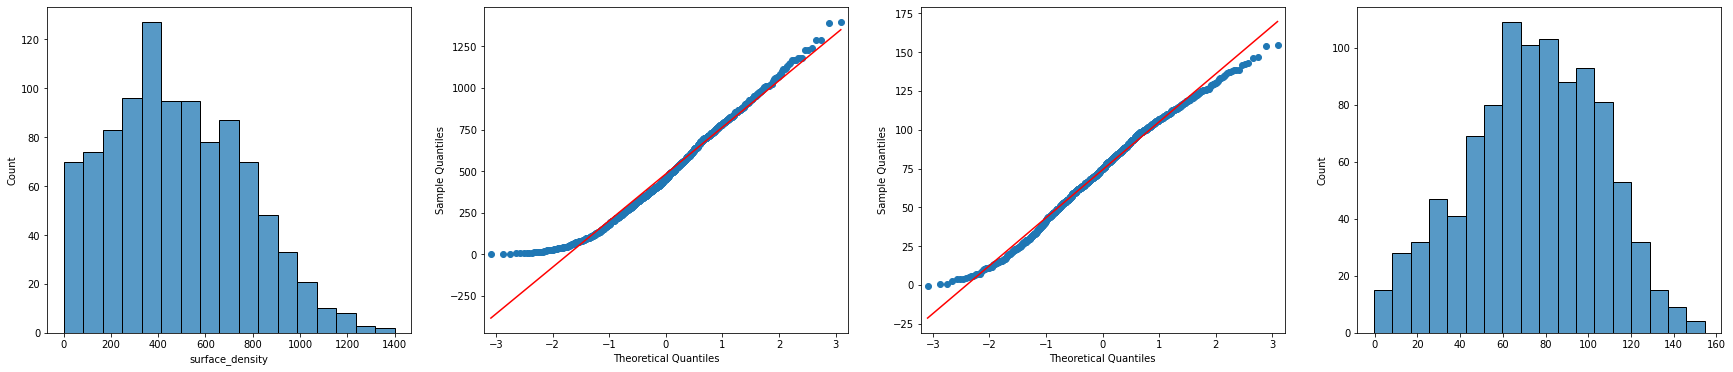

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
sns.histplot(matrix_filler_data['surface_density'], ax=ax[0])
sm.qqplot(matrix_filler_data['surface_density'], line='s', ax=ax[1])
sm.qqplot(boxcox(matrix_filler_data['surface_density'])[0], line='s', ax=ax[2])
sns.histplot(boxcox(matrix_filler_data['surface_density'])[0], ax=ax[3])
plt.show()

In [25]:
# Проверка на отсутствие негативных значений
matrix_filler_data['surface_density'].min() , boxcox(matrix_filler_data['surface_density'].values + 1)[0].min()

(0.603739925153945, 0.5508042842993189)

In [26]:
matrix_filler_data['surface_density_boxcox'], surface_density_boxcox_lambda = boxcox(matrix_filler_data['surface_density'].values + 1)

### Применяем boxcox трансформацию для признака 'cover strength' (плотность нашивки) 

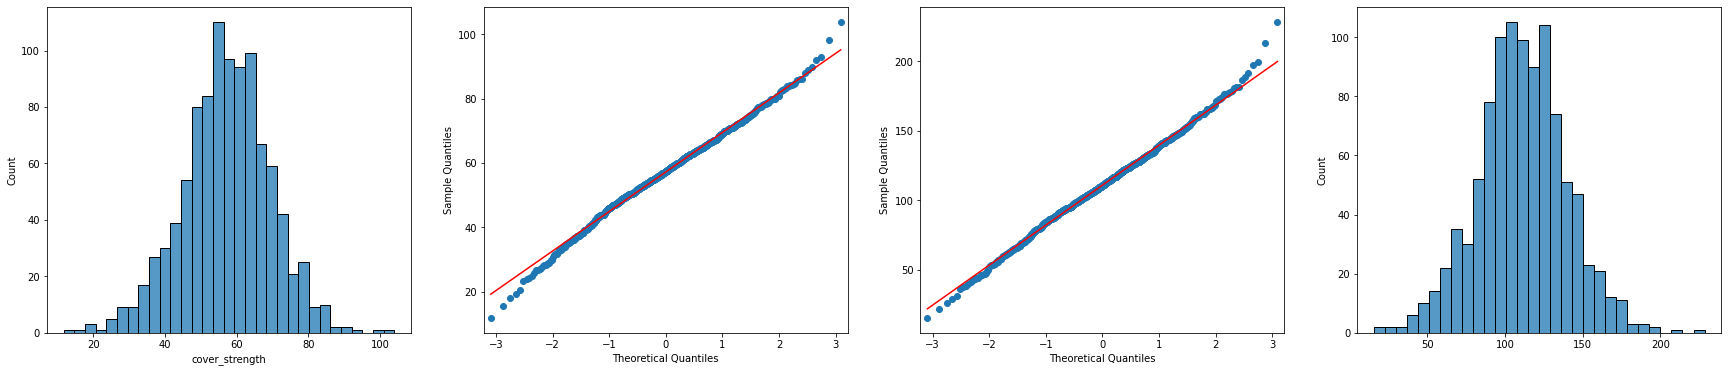

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
sns.histplot(matrix_filler_data['cover_strength'], ax=ax[0])
sm.qqplot(matrix_filler_data['cover_strength'], line='s', ax=ax[1])
sm.qqplot(boxcox(matrix_filler_data['cover_strength'] + 0.001)[0], line='s', ax=ax[2])
sns.histplot(boxcox(matrix_filler_data['cover_strength'] + 0.001)[0], ax=ax[3])
plt.show()

In [28]:
# Проверка на отсутствие негативных значений
matrix_filler_data['cover_strength'].min() , boxcox(matrix_filler_data['cover_strength'].values + 1)[0].min()

(11.7401256604075, 17.31381736884777)

In [29]:
matrix_filler_data['cover_strength_boxcox'], cover_strength_boxcox_lambda = boxcox(matrix_filler_data['cover_strength'].values + 1)

In [30]:
# Удаляем из датасета исходные значения признаков, которые трансформировали черех boxcox преобразование
matrix_filler_data = matrix_filler_data.drop(columns=['elasticity', 'surface_density', 'cover_strength'])
matrix_filler_data.head()

matrix_filler_ratio      density    hardener     epoxid  temperature  \
0             2.587348  1953.274926  137.627420  22.344534   234.716883   
1             2.499918  1942.595777  146.252208  23.081757   351.231874   
2             2.046471  2037.631811  101.617251  23.146393   312.307205   
3             1.856476  2018.220332  135.401697  26.435515   327.510377   
4             3.305535  1917.907506  105.786930  17.874100   328.154579   

   elasticity_on_stretching  solidity_on_stretching       resin  cover_angle  \
0                 80.803222             2587.342983  246.613117            1   
1                 76.178075             3705.672523  226.222760            1   
2                 73.817067             2624.026407  178.198556            1   
3                 77.210762             2473.187195  123.344561            1   
4                 72.345709             3059.032991  275.575880            1   

   cover_step  elasticity_boxcox  surface_density_boxcox  \
0         4.0         468.670776               85.631671   
1         5.0         384.618053              113.823065   
2         5.0         312.793361               84.805005   
3         5.0         360.746332               36.659075   
4         5.0         223.892990               82.700017   

   cover_strength_boxcox  
0             145.526898  
1              90.114645  
2             113.632918  
3             120.868161  
4             145.526898

### Сохраняем значения BoxCox lambdas

In [33]:
matrix_filler_data_lambdas = {
    'elasticity_boxcox_lambda': elasticity_boxcox_lambda,
    'surface_density_boxcox_lambda': surface_density_boxcox_lambda,
    'cover_strength_boxcox_lambda': cover_strength_boxcox_lambda}

matrix_filler_data_lambdas

{'elasticity_boxcox_lambda': 0.8514864751506241,
 'surface_density_boxcox_lambda': 0.6348829215273967,
 'cover_strength_boxcox_lambda': 1.2154612257440889}

<AxesSubplot:>

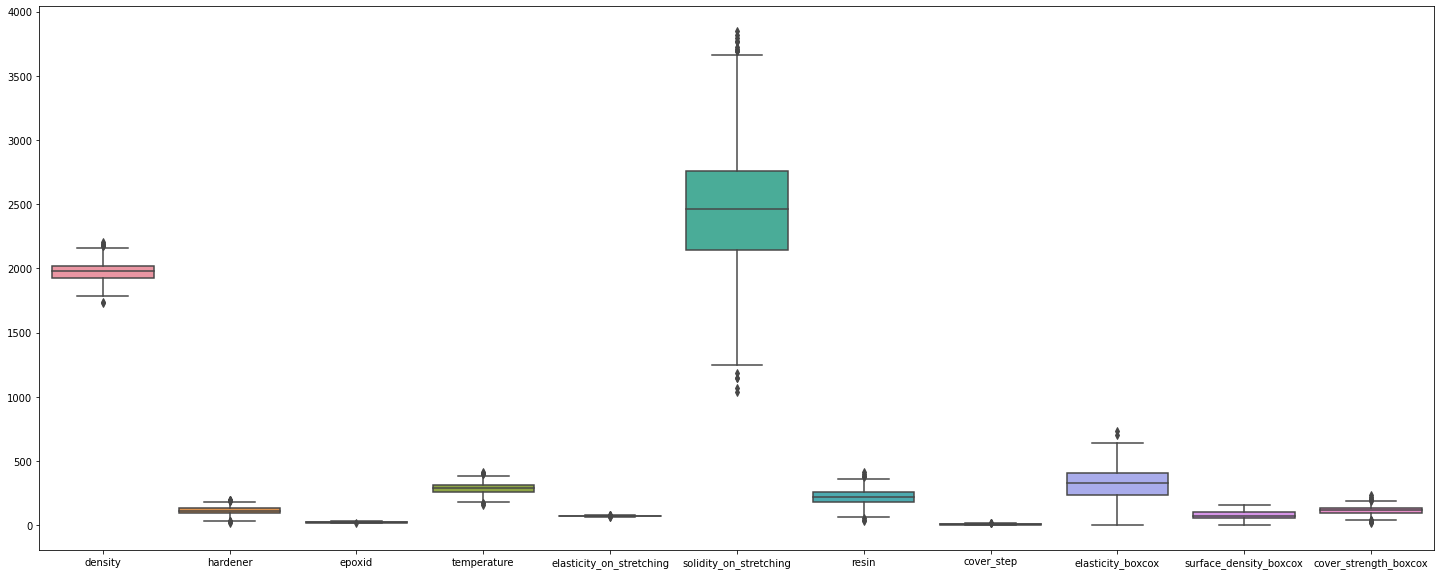

In [36]:
plt.figure(figsize=(25, 10))
sns.boxplot(matrix_filler_data.drop(columns=['matrix_filler_ratio', 'cover_angle']))

### В принципе, можно избавиться от выбросов

In [37]:
# Remove outliers

def compute_IQR_boundaries(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    IQR_bound_lower = data.quantile(0.25) - 1.5 * IQR
    IQR_bound_upper = data.quantile(0.75) + 1.5 * IQR
    return (IQR_bound_lower, IQR_bound_upper)


def detect_outliers(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    IQR_bound_lower = data.quantile(0.25) - 1.5 * IQR
    IQR_bound_upper = data.quantile(0.75) + 1.5 * IQR
    res = [x if (x >= IQR_bound_lower) & (x <= IQR_bound_upper) else np.nan for x in data]
    return res

In [38]:
matrix_filler_data = pd.DataFrame(matrix_filler_data.apply(detect_outliers, axis=0)).dropna().reset_index(drop=True)
matrix_filler_data

matrix_filler_ratio      density    hardener     epoxid  temperature  \
0               2.587348  1953.274926  137.627420  22.344534   234.716883   
1               2.046471  2037.631811  101.617251  23.146393   312.307205   
2               1.856476  2018.220332  135.401697  26.435515   327.510377   
3               3.305535  1917.907506  105.786930  17.874100   328.154579   
4               2.709554  1892.071124   96.563293  22.989291   262.956722   
..                   ...          ...         ...        ...          ...   
916             2.271346  1952.087902   86.992183  20.123249   324.774576   
917             3.444022  2050.089171  145.981978  19.599769   254.215401   
918             3.280604  1972.372865  110.533477  23.957502   248.423047   
919             3.705351  2066.799773  141.397963  19.246945   275.779840   
920             3.808020  1890.413468  129.183416  27.474763   300.952708   

     elasticity_on_stretching  solidity_on_stretching       resin  \
0                   80.803222             2587.342983  246.613117   
1                   73.817067             2624.026407  178.198556   
2                   77.210762             2473.187195  123.344561   
3                   72.345709             3059.032991  275.575880   
4                   74.511359             2288.967377  126.816339   
..                        ...                     ...         ...   
916                 73.090961             2387.292495  125.007669   
917                 72.920827             2360.392784  117.730099   
918                 74.734344             2662.906040  236.606764   
919                 74.042708             2071.715856  197.126067   
920                 74.309704             2856.328932  194.754342   

     cover_angle  cover_step  elasticity_boxcox  surface_density_boxcox  \
0              1    4.000000         468.670776               85.631671   
1              1    5.000000         312.793361               84.805005   
2              1    5.000000         360.746332               36.659075   
3              1    5.000000         223.892990               82.700017   
4              1    7.000000         287.514837              108.667505   
..           ...         ...                ...                     ...   
916            1    9.076380         388.740128               45.403985   
917            1   10.565614         210.404942               63.557294   
918            1    4.161154         199.076146              102.983095   
919            1    6.313201         325.540723               93.916114   
920            1    6.078902         199.271889              104.641953   

     cover_strength_boxcox  
0               145.526898  
1               113.632918  
2               120.868161  
3               145.526898  
4                90.114645  
..                     ...  
916              90.160173  
917             105.887238  
918             139.609893  
919             116.664723  
920             164.357714  

[921 rows x 13 columns]

<AxesSubplot:>

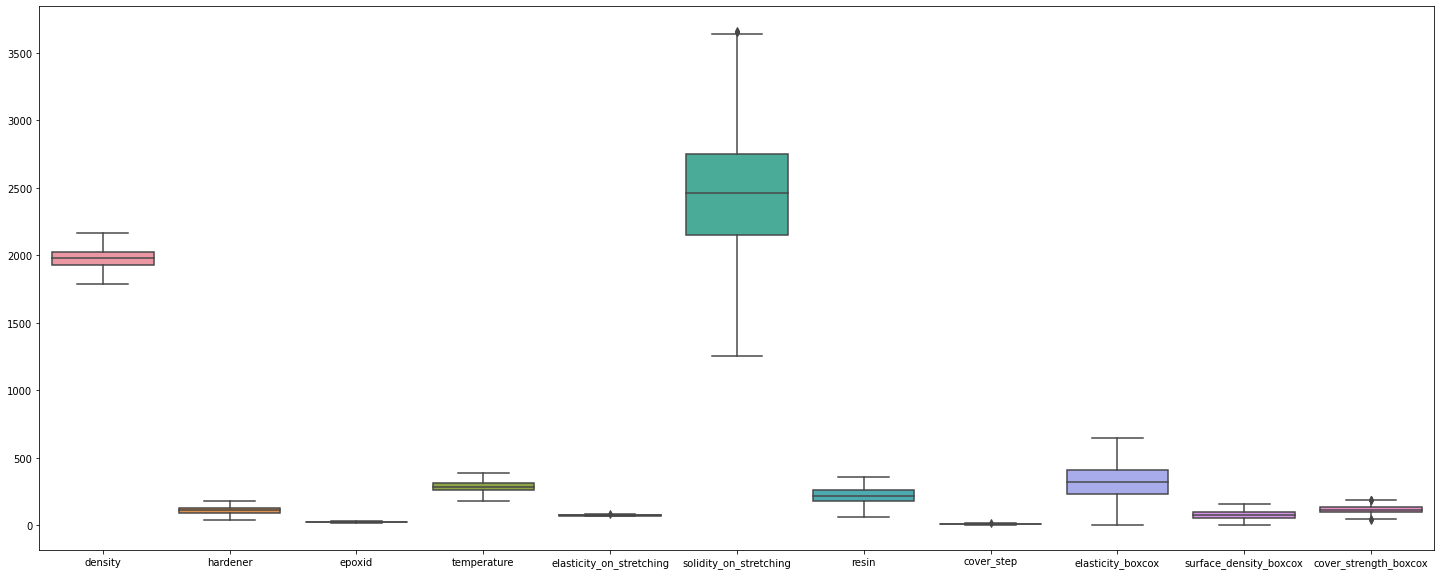

In [41]:
plt.figure(figsize=(25, 10))
sns.boxplot(matrix_filler_data.drop(columns=['matrix_filler_ratio', 'cover_angle']))

### Сохраняем финальный датасет для обучения моделей.

In [42]:
matrix_filler_data.to_csv('../data/data_for_model/matrix_filler_data_to_use.csv', sep=';', index=True)

# А что если ещё...

### Если нет линейной зависимости (отсутствует корреляция) между целевой переменной и признаками, взятыми по-отдельности / по-одному (т.е. по вертикали = feature-wise), то, возможно, целевая переменная "реагирует" на набор признаков, как единое целое, как "рецепт"/состав композитного материала, т.е. важная взаимосвязь признаков между собой по горизонтали - по строкам (sample-wise).   

### Тогда можно предположить, что относительно схожим значениям целевой переменной (т.е. разница д.б. близка к 0 или около того) должны соответствовать оносительтно схожие по своему составу ("рецепту") испытываемые образцы композитных материалов.

### Отсюда сделаем следующее упражнение... Попарно сравним все наблюдения (эксперименты) между собой на предмет схожести / разности через косинусное расстояние между векторами признаков и при этом будет фиксировать разницу между значениями целевой переменной сравниваемых векторов (= "рецептуры" композитных материалов). 

In [43]:
matrix_filler_data = pd.read_csv('../data/data_for_model/matrix_filler_data_to_use.csv', sep=';', index_col=[0])

In [44]:
# Убираем категориальную переменную (она просто даёт би-модальное распределение) и нормализуем данные.
cover_angle = matrix_filler_data.pop('cover_angle')
data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(matrix_filler_data), index=matrix_filler_data.index, columns=matrix_filler_data.columns)
# data_scaled = pd.concat([data_scaled, cover_angle], axis=1)
data_scaled

matrix_filler_ratio   density  hardener    epoxid  temperature  \
0               0.427955  0.447627  0.697727  0.501436     0.267751   
1               0.314487  0.671337  0.451468  0.561912     0.643139   
2               0.274628  0.619859  0.682506  0.809975     0.716694   
3               0.578621  0.353835  0.479982  0.164279     0.719810   
4               0.453592  0.285319  0.416906  0.550063     0.404378   
..                   ...       ...       ...       ...          ...   
916             0.361662  0.444480  0.351453  0.333908     0.703458   
917             0.607674  0.704373  0.754860  0.294428     0.362087   
918             0.573391  0.498274  0.512442  0.623085     0.334063   
919             0.662497  0.748688  0.723512  0.267818     0.466417   
920             0.684036  0.280923  0.639982  0.888354     0.588206   

     elasticity_on_stretching  solidity_on_stretching     resin  cover_step  \
0                    0.961302                0.554738  0.619323    0.289334   
1                    0.520918                0.569959  0.387697    0.362355   
2                    0.734845                0.507371  0.201982    0.362355   
3                    0.428168                0.750455  0.717380    0.362355   
4                    0.564684                0.430934  0.213737    0.508396   
..                        ...                     ...       ...         ...   
916                  0.475147                0.471731  0.207613    0.660014   
917                  0.464422                0.460570  0.182974    0.768759   
918                  0.578740                0.586091  0.585446    0.301102   
919                  0.535142                0.340790  0.451779    0.458245   
920                  0.551972                0.666348  0.443749    0.441137   

     elasticity_boxcox  surface_density_boxcox  cover_strength_boxcox  
0             0.727020                0.550721               0.716005  
1             0.484084                0.545370               0.495298  
2             0.558819                0.233725               0.545366  
3             0.345532                0.531744               0.716005  
4             0.444688                0.699829               0.332551  
..                 ...                     ...                    ...  
916           0.602448                0.290330               0.332866  
917           0.324511                0.407835               0.441698  
918           0.306855                0.663035               0.675059  
919           0.503951                0.604345               0.516278  
920           0.307160                0.673772               0.846315  

[921 rows x 12 columns]

In [45]:
similarity_res = []
used_rows = []

for i in data_scaled.index.tolist():
    used_rows.append(i)
    target_master = data_scaled.loc[i, data_scaled.columns.tolist()[0]] 
    array_master = np.expand_dims(data_scaled.loc[i, data_scaled.columns.tolist()[1:]].values, axis=0)
    subset = data_scaled.drop(index=i)
    for j in subset.index.tolist():
        if j not in used_rows:
            target_pair = subset.loc[j, subset.columns.tolist()[0]]
            array_pair = np.expand_dims(subset.loc[j, subset.columns.tolist()[1:]].values, axis=0)
            # target_diff = np.abs(target_master - target_pair)
            target_diff = target_master - target_pair
            cosin_sim = cosine_similarity(array_master, array_pair).ravel()[0]
            similarity_res.append((target_diff, cosin_sim))

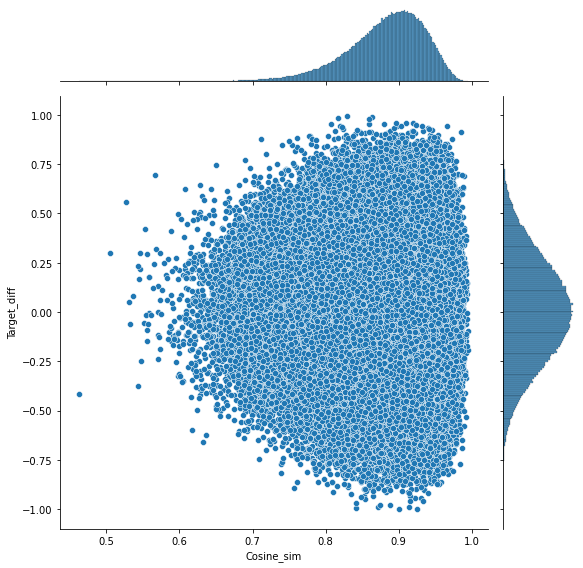

In [46]:
similarity_df = pd.DataFrame(similarity_res, columns=['Target_diff', 'Cosine_sim'])
sns.jointplot(data=similarity_df, x='Cosine_sim', y='Target_diff', height=8)

In [47]:
np.corrcoef(similarity_df['Cosine_sim'], similarity_df['Target_diff'])[0][1]

-0.018448893683180985

### Получается странная картина... чем менее схожи попарно между собой эксперименты по "рецептуре" (т.е. меньше косинусное расстояние), тем меньше разница в целевых переменных и наоборот - чем выше сходство (косинусное расстояние ближе к 1), тем больше разница между получаемыми значениями целевой переменной. 

### Вывод: 
### Классическая регрессия, скорее всего, не сработает, в т.ч. разбиение на train-test. Возможно, более правильным (но в тоже время - ресурсоёмким) решением будет сравнение моделей через LeaveOneOut кросс-валидацию.
### Другой вариант - от задачи регресии перейти к задаче классификации, разбив целевую переменную на интервалы (bins) = классы, и каждый класс будет соответствовать среднему значению целевой переменной в заданном интервале.

In [ ]:
# def assign_hist_bin_number(data, n_bins=10):
#     _, binEdges = np.histogram(data, bins=n_bins)
#     bin_numbers = [[i + 1  for i in np.arange(n_bins) if (x >= binEdges[i]) & (x <= binEdges[i + 1])] for x in data]
#     return bin_numbers

In [ ]:
# bins = pd.DataFrame(data_elasticity.drop(columns=['cover_angle']).apply(assign_hist_bin_number, axis=0)).dropna().reset_index(drop=True).apply(lambda x: sum(x, []), axis=1).to_frame()
# bins = pd.DataFrame(data_elasticity.drop(columns=['cover_angle']).apply(assign_hist_bin_number, axis=0)).apply(lambda x: sum(x, []), axis=1).to_frame()
# bins_df = bins[0].apply(pd.Series)
# bins_df.columns = data_elasticity.drop(columns=['cover_angle']).columns
# bins_df

In [ ]:
# bins_df.isna().sum()

In [ ]:
# y_bin_labels = bins_df['elasticity_on_stretching'].unique().astype(int)
# y_bins_matched = {}
# y_bins_missmatched = {}

# for y_label in y_bin_labels:    
#     subset = bins_df.loc[bins_df['elasticity_on_stretching'] == y_label, bins_df.columns[1:]]    
#     for idx in subset.index:
#         row_main = subset.loc[idx, :].values
#         subset_2 = subset.drop(index=[idx])
#         for idx_2 in subset_2.index:
#             row_compare = subset_2.loc[idx_2, :].values
#             if np.sum(np.abs(np.subtract(row_main, row_compare))) == 0:
#                 y_bins_matched.setdefault(y_label, []).append((idx, idx_2))
#             else:
#                 y_bins_missmatched.setdefault(y_label, []).append((idx, idx_2))

In [ ]:
# all_y_bins_matched = []
# all_y_bins_missmatched = []

# for idx in bins_df.index:
#     row_main = bins_df.loc[idx, :].values
#     subset = bins_df.drop(index=[idx])
#     for idx_2 in subset.index:
#         row_compare = subset.loc[idx_2, :].values
#         if np.sum(np.abs(np.subtract(row_main, row_compare))) == 0:
#             all_y_bins_matched.append((idx, idx_2))
#         else:
#             all_y_bins_missmatched.append((idx, idx_2))

In [ ]:
# y_bins_matched

In [ ]:
# y_bins_missmatched